In [1]:
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.stats import t
df = pd.read_csv('Family Income and Expenditure.csv')

In [2]:
# ------- TESTE DE HIPÓTESE DE DIFERENÇA DE MÉDIAS, INTERVALO DE CONFIANÇA, TESTE QUI-QUADRADO

# teste de hipótese para diferença entre médias (as duas amostras são de 20 elementos)
def mean_difference_hypothesis_test(series_x, series_y, equal_var, n = 20):
    
    sample_x = series_x.sample(n)
    sample_y = series_y.sample(n)
    
    xbar = np.mean(sample_x)
    ybar = np.mean(sample_y)
    
    sx = np.std(sample_x)
    sy = np.std(sample_y)
    
    if equal_var == False:
        
        a = (sx ** 2) / n
        b = (sy ** 2) / n
        df =               ((a + b) ** 2) / \
             ( ((a ** 2) / (n - 1)) + ((b ** 2) / (n - 1)) )
        t = (xbar - ybar) / (np.sqrt(a + b))
        
        return (t, df)
    
    if equal_var == True: 
        
        df = n + n - 2
        sp2 =     ( (n - 1) * (sx ** 2) + (n - 1) * (sy ** 2) ) / \
                                            df
        sp = np.sqrt(sp2)
        t = (xbar - ybar) / (sp * np.sqrt((1 / n) + (1 / n)))
        
        return (t, df)

# intervalo de confiança
# valor-z para 95%(bicaudal) <-- 1.96
def CI(series, n = 100, zval = 1.96): 
    
    sample = series.sample(n)
    xbar = np.mean(sample)
    sx = np.std(sample)
    moe = zval * (sx / np.sqrt(n))
    
    return (round(xbar - moe, 2), round(xbar + moe, 2))

# teste de hipótese para independência entre variáveis
# valor crítico para alpha = 0.05, 2 graus de liberdade((n_linhas - 1) * (n_colunas - 1)) <-- 5.991
def chi2_2by3_contingency(ct):  
    
    line1_proportion = ct.iloc[0].sum() / (ct.iloc[0].sum() + ct.iloc[1].sum())
    line2_proportion = ct.iloc[1].sum() / (ct.iloc[0].sum() + ct.iloc[1].sum())
    observed_flat_ct = ct.iloc[0].tolist() + ct.iloc[1].tolist()
    expected_flat_ct = [line1_proportion * ct[ct.columns[0]].sum(), line1_proportion * ct[ct.columns[1]].sum(),
                        line1_proportion * ct[ct.columns[2]].sum(), line2_proportion * ct[ct.columns[0]].sum(),
                        line2_proportion * ct[ct.columns[1]].sum(), line2_proportion * ct[ct.columns[2]].sum()]
    chi_obs = 0
    for n in range(0, len(expected_flat_ct)):
        
        chi_obs += ((observed_flat_ct[n] - expected_flat_ct[n]) ** 2) / expected_flat_ct[n]
        
    return chi_obs

# ------- DISTRIBUIÇÃO AMOSTRAL DE PROPORÇÕES / TESTE DE HIPÓTESE DE DIFERENÇA DE VARIÂNCIAS

# distribuição amostral de proporções de variâncias amostrais 
def variance_ratio_sampling_distribution(series_x, series_y, sample_size = 100, n_of_samples = 1000):
    
    var_ratio_list = []
    for n in range(0, n_of_samples):
        
        var_x = np.var(series_x.sample(sample_size))
        var_y = np.var(series_y.sample(sample_size))
        var_ratio_list.append(var_x / var_y)
        
    plt.title('DISTRIBUIÇÃO AMOSTRAL DE PORPORÇÕES DE VARIÂNCIAS AMOSTRAIS')
    plt.hist(var_ratio_list, bins = 50)
    plt.show()
    
# teste de hipótese de diferença de variâncias (tamanho amostral = 21, para ter valor crítico fixo)
# valor crítico para alpha = 0.05, 20 graus de liberdade <-- 2.12
def variance_difference_hypothesis_test(series_x, series_y):
    
    sample_x = series_x.sample(21)
    sample_y = series_y.sample(21)
    
    if np.var(sample_x) >= np.var(sample_y):
        f = np.var(sample_x) / np.var(sample_y)
        
    if np.var(sample_x) < np.var(sample_y):
        f = np.var(sample_y) / np.var(sample_x)
        
    print('Valor f: {0}\nValor Crítico(f): 2.12'.format(round(f, 2)))
    
# ELIMINAR OUTLIERS

# infrormações sobre dados após eliminar percentis(hipoteticamente)
def outlier_by_percentile(series, upper_limit, lower_limit):    
    
    s_aux = series.sort_values() 
    upper_n_to_drop = round(len(series) * ((100 - upper_limit) / 100))
    lower_n_to_drop = round(len(series) * (lower_limit / 100))
    series_below_ht = s_aux.drop(s_aux.tail(upper_n_to_drop).index)
    series_above_lt = s_aux.drop(s_aux.head(lower_n_to_drop).index)
    series_between_lt_ht = s_aux.drop(s_aux.head(lower_n_to_drop).index).drop(s_aux.tail(upper_n_to_drop).index)
    
    print('MÉDIA APÓS ELIMINAR PERCENTIL {} PARA CIMA:'.format(upper_limit), round(series_below_ht.mean(), 2))
    print('            //                {} PARA BAIXO:'.format(lower_limit), round(series_above_lt.mean(), 2))
    print('            //                {1} PARA CIMA E {0} PARA BAIXO:'.format(lower_limit,
        upper_limit), round(series_between_lt_ht.mean(), 2))
    print('-----------------------------------------------------------------------------------')
    print('VARIAÇÃO PERCENTUAL APÓS ELIMINAR PERCENTIL {} PARA CIMA: '.format(upper_limit),
       round(((series_below_ht.mean() - series.mean()) / series.mean()) * 100, 2), '%')
    print('                 //                         {} PARA BAIXO: '.format(lower_limit),
      round(((series_above_lt.mean() - series.mean()) / series.mean()) * 100, 2), '%')
    print('                 //                         {0} PARA CIMA e {1} PARA BAIXO: '.format(upper_limit,
    lower_limit), round(((series_between_lt_ht.mean() - series.mean()) / series.mean()) * 100, 2), '%')
        
# remoção de dados por percentil
def drop_by_percentile(series, upper_limit = 90, lower_limit = 0):
    
    s_aux = series.sort_values() 
    upper_n_to_drop = round(len(series) * ((100 - upper_limit) / 100))
    lower_n_to_drop = round(len(series) * (lower_limit / 100))
    series_between_lt_ht = s_aux.drop(s_aux.head(lower_n_to_drop).index).drop(s_aux.tail(upper_n_to_drop).index)
    
    return series_between_lt_ht

### MILESTONE 1
# AMOSTRA DE 100 ELEMENTOS

In [3]:
# df.sample(100)

### MILESTONE 1
# ANÁLISE PRELIMINAR

In [4]:
# para poder entender melhor o dataset, primeiramente, divido as variáveis entre quantitativas e qualitativas
# posteriormente, em virtude da grande quantidade de variáveis quantitativas, divido as mesmas de acordo
# com palavras chave

# quantitative / qualitative variable split
def quali_quant_series_names(dataframe):
    series_analysis = []
    quant_vars = []
    quali_vars = []
    
    for col in dataframe.columns:  
        series_analysis.append([dataframe[col].unique()[0], col, len(dataframe[col].unique())])
        
    for i in series_analysis:
    
        if str(i[0]).isnumeric() and i[2] > 3:
            quant_vars.append(i[1])
            
        else:
            quali_vars.append(i[1]) 
            
    return (quali_vars, quant_vars)

# quantitative variables split by key word
def quant_vars_split(quant):
    income = []
    expenditure = []
    age = []
    members = []
    number = []
    other = []
    
    for var in quant:
        
        if 'income' in var.split(' ') or 'Income' in var.split(' '):
            income.append(var)
            
        elif 'expenditure' in var.split(' ') or 'Expenditure' in var.split(' '):
            expenditure.append(var)
            
        elif 'age' in var.split(' ') or 'Age' in var.split(' '):
            age.append(var)
            
        elif 'members' in var.split(' ') or 'Members' in var.split(' '):
            members.append(var)
            
        elif 'Number' in var.split(' ') or 'number' in var.split(' '):
            number.append(var) 
            
        else:
            other.append(var)
            
    return (income, expenditure, age, members, number, other)

quali, quant = quali_quant_series_names(df)
income, expenditure, age, members, number, other = quant_vars_split(quant)
print('QUALITATIVAS:', quali)
print('')
print('QUANTITATIVAS:', quant)
# print('DIVISÃO DE VARIÁVEIS QUANTITATIVAS:')                      <-- variáveis divididas por palavra chave
# for key_word in [income, expenditure, age, members, number, other]: 
#     print(key_word)
#     print('')

QUALITATIVAS: ['Region', 'Main Source of Income', 'Agricultural Household indicator', 'Household Head Sex', 'Household Head Marital Status', 'Household Head Highest Grade Completed', 'Household Head Job or Business Indicator', 'Household Head Occupation', 'Household Head Class of Worker', 'Type of Household', 'Type of Building/House', 'Type of Roof', 'Type of Walls', 'Tenure Status', 'Toilet Facilities', 'Electricity', 'Main Source of Water Supply']

QUANTITATIVAS: ['Total Household Income', 'Total Food Expenditure', 'Bread and Cereals Expenditure', 'Total Rice Expenditure', 'Meat Expenditure', 'Total Fish and  marine products Expenditure', 'Fruit Expenditure', 'Vegetables Expenditure', 'Restaurant and hotels Expenditure', 'Alcoholic Beverages Expenditure', 'Tobacco Expenditure', 'Clothing, Footwear and Other Wear Expenditure', 'Housing and water Expenditure', 'Imputed House Rental Value', 'Medical Care Expenditure', 'Transportation Expenditure', 'Communication Expenditure', 'Education

### MILESTONE 1
# ANÁLISE 1(RENDA MÉDIA DE CADA REGIÃO)

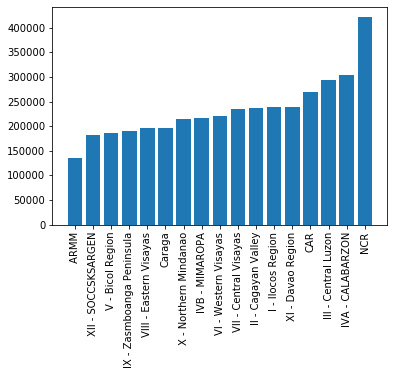

In [5]:
plt.bar(df.groupby('Region').mean().sort_values('Total Household Income')['Total Household Income'].index,
       df.groupby('Region').mean().sort_values('Total Household Income')['Total Household Income'])
plt.xticks(rotation = 90)
plt.show()

# percebe-se que a região 'NCR' possui renda média consideravelmente mais alta do que as demais regiões

### MILESTONE 1
# ANÁLISE 2(CRIANÇAS / ADULTOS POR LAR)

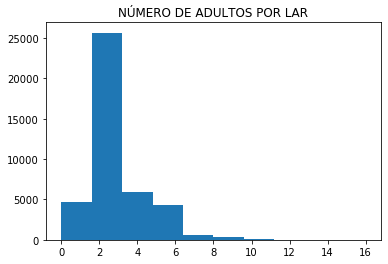

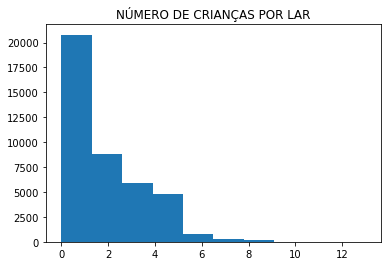

LARES COM APENAS ADULTOS: 27.65 %
LARES COM APENAS CRIANÇAS 0.35 %

POPULAÇÃO DE CRIANÇAS: 38.0 %
POPULAÇÃO DE ADULTOS: 62.0 %


In [6]:
# em alguns dados, o número total de membros da família é menor do que o número de membros com 0-17 anos,
# desconsiderei estes

df_m1_a2 = df.loc[df['Total Number of Family members'] >=
    (df['Members with age 5 - 17 years old'] + df['Members with age less than 5 year old'])]

df_m1_a2['child_count'] = df_m1_a2['Members with age 5 - 17 years old'] + \
                          df_m1_a2['Members with age less than 5 year old']
df_m1_a2['adult_count'] = df_m1_a2['Total Number of Family members'] - df_m1_a2['child_count']
clear_output()

plt.hist(df_m1_a2['adult_count'])
plt.title('NÚMERO DE ADULTOS POR LAR')
plt.show()

plt.hist(df_m1_a2['child_count'])
plt.title('NÚMERO DE CRIANÇAS POR LAR')
plt.show()

print('LARES COM APENAS ADULTOS:', 
      round((len(df_m1_a2.loc[df_m1_a2['child_count'] == 0]) / len(df_m1_a2)) * 100, 2), '%')
print('LARES COM APENAS CRIANÇAS', 
      round((len(df_m1_a2.loc[df_m1_a2['adult_count'] == 0]) / len(df_m1_a2)) * 100, 2), '%')
print('')
print('POPULAÇÃO DE CRIANÇAS:',
      round((df_m1_a2['child_count'].sum() / df_m1_a2['Total Number of Family members'].sum() * 100)), '%')
print('POPULAÇÃO DE ADULTOS:', 
      round((df_m1_a2['adult_count'].sum() / df_m1_a2['Total Number of Family members'].sum() * 100)), '%')

### MILESTONE 1
# ANÁLISE 3(RURALIDADE)

In [7]:
# ANÁLISE DE RURALIDADE
# como existem três possíveis valores para 'Agricultural Household indicator', primeiramente devo eliminar 
# um deles ou alocar os dados de dois valores sob o um único para tanto, verificarei que proporção dos dados 
# possui cada valor de 'Agricultural Household indicator', quantas regiões cada um engloba e o 
# 'Crop Farming and Gardening expenses' de cada grupo

# cálculo da média de gastos de cada indicador, caso fossem eliminados outliers de percentil 95 para cima
def agricultural_val_analysis(dataframe, ag_ind, upper_limit, lower_limit):
    aux = 'Agricultural Household indicator'
    aux_2 = 'Crop Farming and Gardening expenses'
    
    df_by_ag_ind = dataframe.loc[dataframe[aux] == ag_ind]
    farm_exp_series = drop_by_percentile(df_by_ag_ind[aux_2], upper_limit, lower_limit)
    
    s2 = "número de regiões que possuem pelo menos um dado com valor {0} em '{1}':"
    s3 = "'{2}' médio dos dados cujo '{1}' é {0}:"
    s4 = "porcentagem do toal de dados composta por este grupo: {}"
    
    print(s2.format(ag_ind, aux), len(df_by_ag_ind['Region'].unique()))
    print(s3.format(ag_ind, aux, aux_2), round(farm_exp_series.mean()))
    print(s4.format(round(len(df_by_ag_ind)/len(dataframe), 3) * 100), '%')
    
df_m1_a3 = df.copy()

for ag_ind in df_m1_a3['Agricultural Household indicator'].unique():
    print("'Agricultural Household indicator' --> {}".format(ag_ind))
    agricultural_val_analysis(df_m1_a3, ag_ind, 95, 0)
    print('')

'Agricultural Household indicator' --> 0
número de regiões que possuem pelo menos um dado com valor 0 em 'Agricultural Household indicator': 17
'Crop Farming and Gardening expenses' médio dos dados cujo 'Agricultural Household indicator' é 0: 2613.0
porcentagem do toal de dados composta por este grupo: 67.7 %

'Agricultural Household indicator' --> 1
número de regiões que possuem pelo menos um dado com valor 1 em 'Agricultural Household indicator': 17
'Crop Farming and Gardening expenses' médio dos dados cujo 'Agricultural Household indicator' é 1: 30196.0
porcentagem do toal de dados composta por este grupo: 21.7 %

'Agricultural Household indicator' --> 2
número de regiões que possuem pelo menos um dado com valor 2 em 'Agricultural Household indicator': 8
'Crop Farming and Gardening expenses' médio dos dados cujo 'Agricultural Household indicator' é 2: 4.0
porcentagem do toal de dados composta por este grupo: 10.6 %



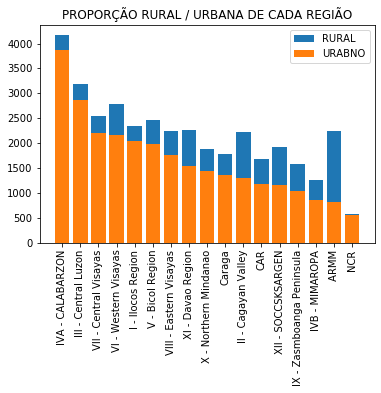

In [8]:
# dados cujo 'Agricultural Household indicator' é igual a 2 possuem 'Crop Farming and Gardening expenses'
# baixo, à partir disto, suponho que não se trate de área rural, além disso, consiste em proporção pequena dos
# dados, assim sendo, para esta análise, não considerarei os mesmos daqui para frente
df_urbano = df.loc[df['Agricultural Household indicator'] == 0]
df_rural = df.loc[df['Agricultural Household indicator'] == 1]

urban_region_val_count = df_urbano['Region'].value_counts().to_frame()
rural_region_val_count = df_rural['Region'].value_counts().to_frame()

df_urbanXrural = urban_region_val_count.merge(rural_region_val_count, left_index = True, right_index = True)
df_urbanXrural.columns = ['urban', 'rural']
df_urbanXrural['aux_val'] = df_urbanXrural['urban'] + df_urbanXrural['rural']

plt.bar(df_urbanXrural.index, df_urbanXrural['aux_val'], label = 'RURAL')
plt.bar(df_urbanXrural.index, df_urbanXrural['urban'], label = 'URABNO')
plt.title('PROPORÇÃO RURAL / URBANA DE CADA REGIÃO')
plt.xticks(rotation = 90)
plt.legend()
plt.show()

# a área mais urbanizada é NCR, também é a menor e de acordo com a análise 1, a mais rica

### MILESTONE 1
# ANÁLISE 4(DESEMPREGO)

In [9]:
# considero que apenas adultos possam estar ou não empregados
df_m1_a4 = df.loc[df['Total Number of Family members'] >=
    (df['Members with age 5 - 17 years old'] + df['Members with age less than 5 year old'])]

df_m1_a4['child_count'] = df_m1_a4['Members with age 5 - 17 years old'] + \
                          df_m1_a4['Members with age less than 5 year old']
df_m1_a4['adult_count'] = df_m1_a4['Total Number of Family members'] - df_m1_a4['child_count']
clear_output()

unemployed = df_m1_a4['adult_count'].sum() - df_m1_a4['Total number of family members employed'].sum()

print('DESEMPREGADOS:', round((unemployed / df_m1_a4['adult_count'].sum()) * 100, 2), '%')

DESEMPREGADOS: 55.56 %


### MILESTONE 1
# ANÁLISE 5(COMO A POPULAÇÃO GASTA SEU DINHEIRO)

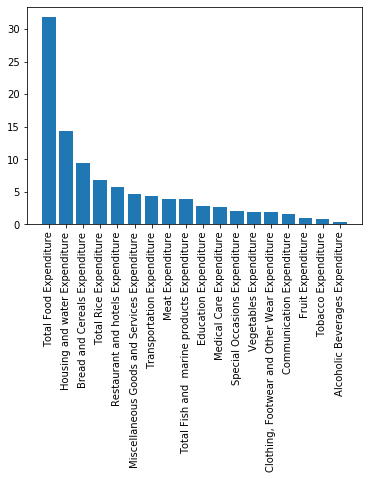

In [10]:
# as barras indicam que porcentagem do 'expenditure' total de cada lar, cada tipo de 'expenditure' representa
expenditure_series_list = []
for col in df.columns:
    if 'Expenditure' in col or 'expenditure' in col:
        expenditure_series_list.append(col)   
        
expenditure_sum_list = []
exp_to_frame = []
for exp_type in expenditure_series_list:
    expenditure_sum_list.append([exp_type, df[exp_type].sum()])   
m1_a5_aux_df = pd.DataFrame(expenditure_sum_list, columns = ['type', 'total'])
m1_a5_aux_df['proportion'] = (m1_a5_aux_df['total'] / m1_a5_aux_df['total'].sum()) * 100
m1_a5_aux_df.sort_values('proportion', ascending = False, inplace = True)

plt.bar(m1_a5_aux_df['type'], m1_a5_aux_df['proportion'])
plt.xticks(rotation = 90)
plt.show()

### MILESTONE 1
# ANÁLISE 6(DISTRIBUIÇÃO DE VARIÁVEIS QUANTITATIVAS)

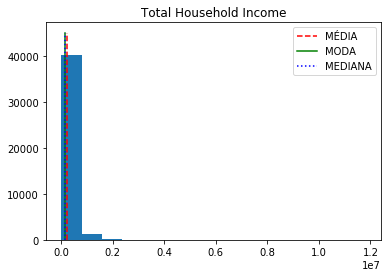

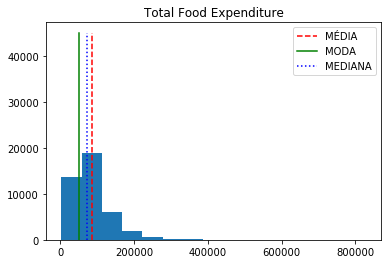

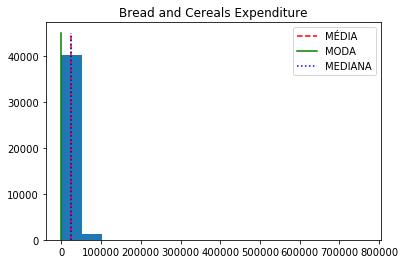

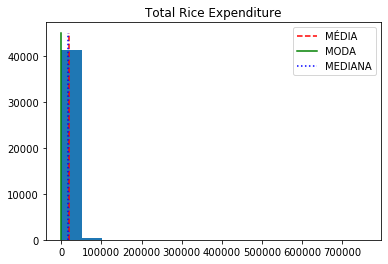

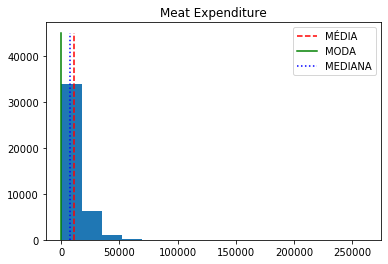

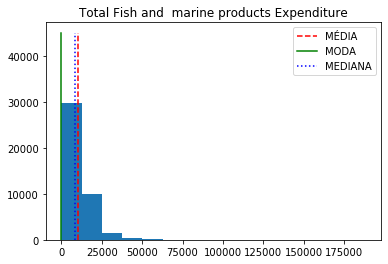

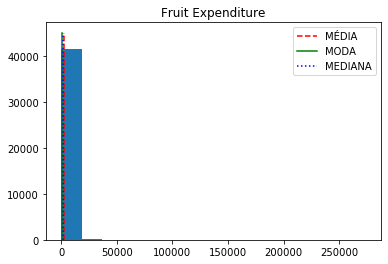

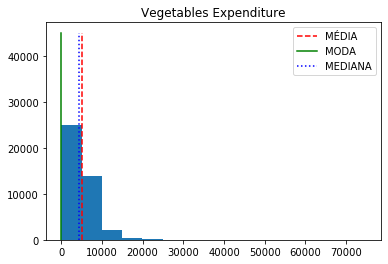

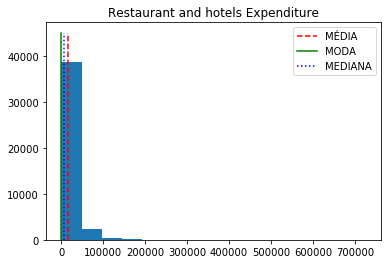

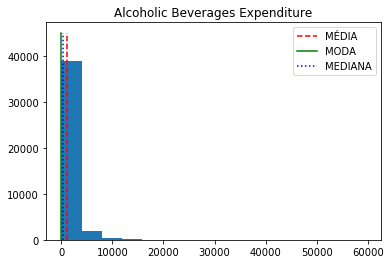

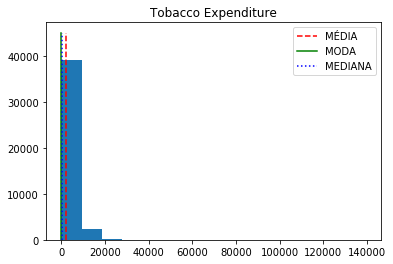

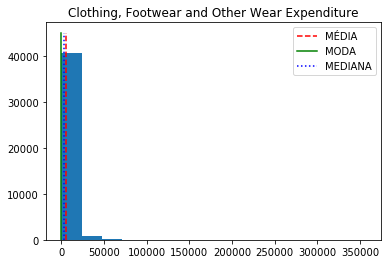

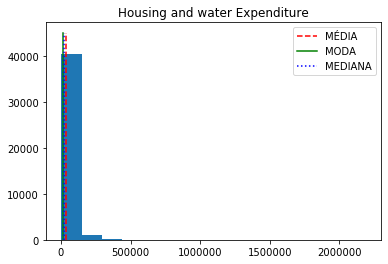

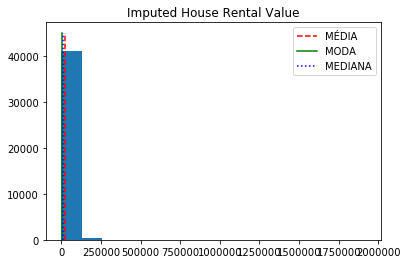

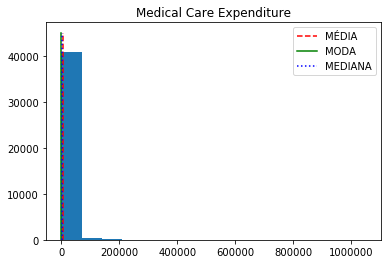

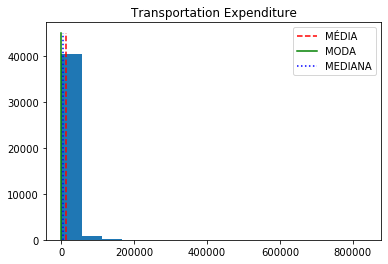

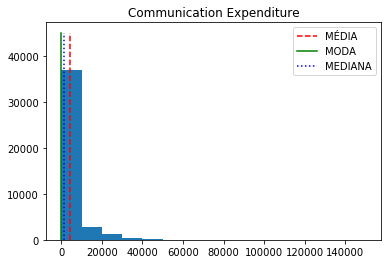

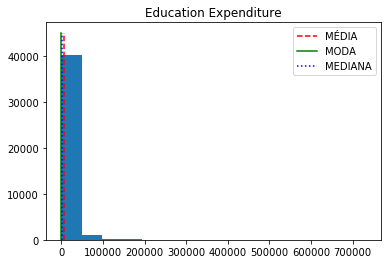

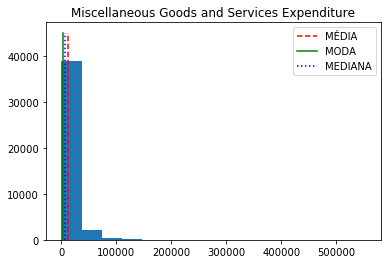

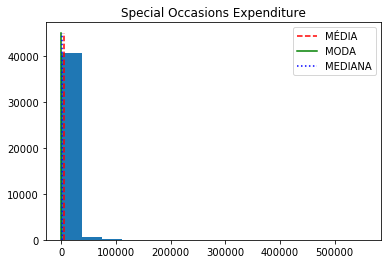

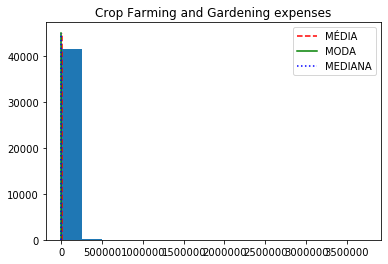

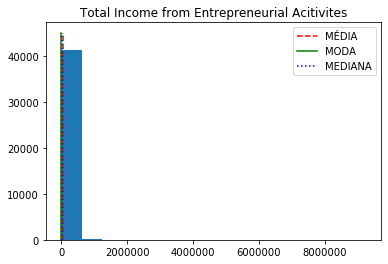

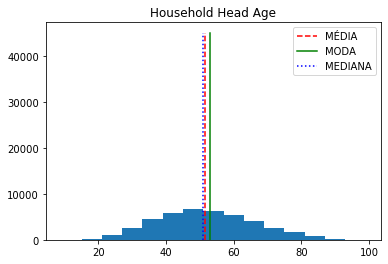

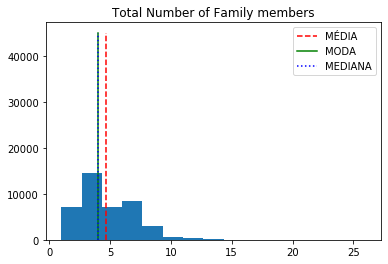

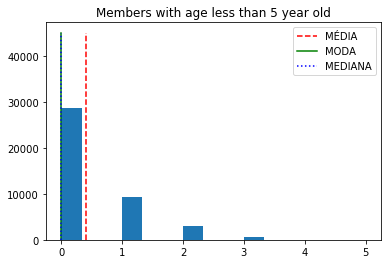

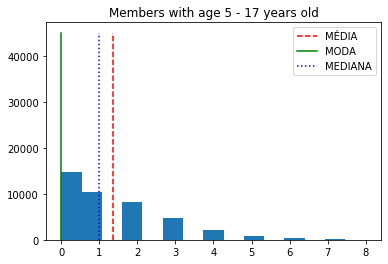

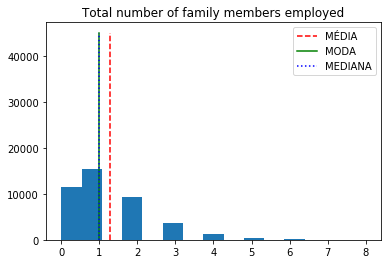

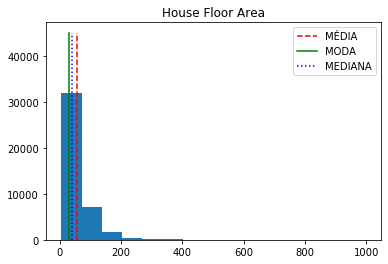

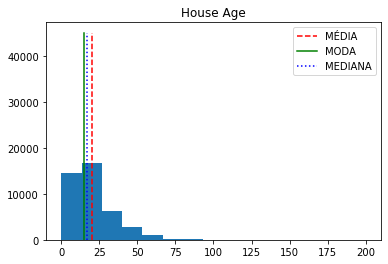

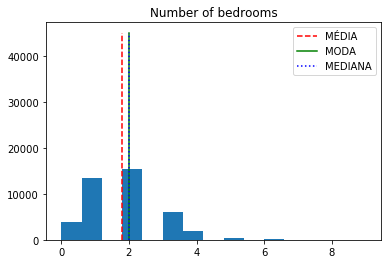

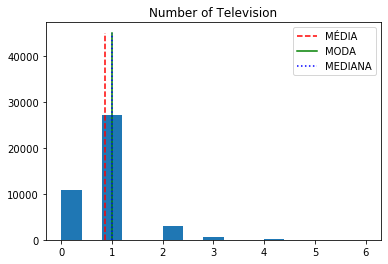

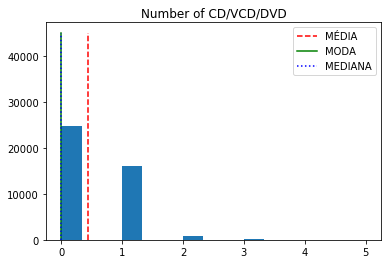

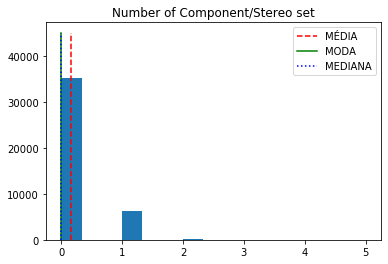

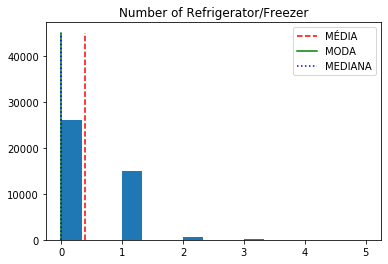

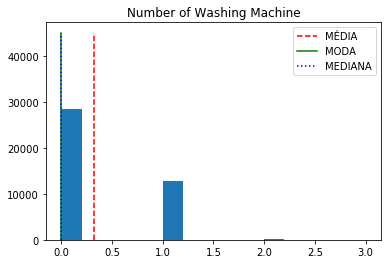

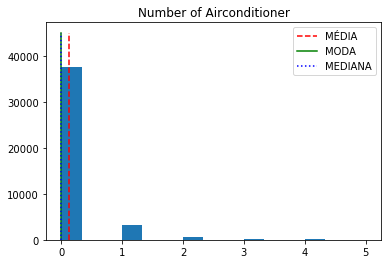

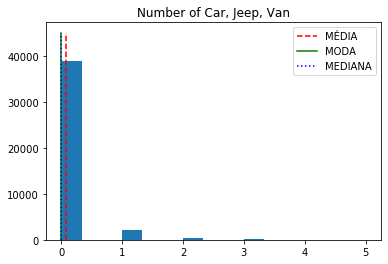

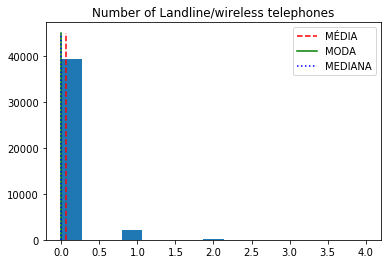

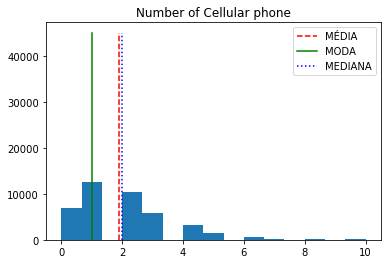

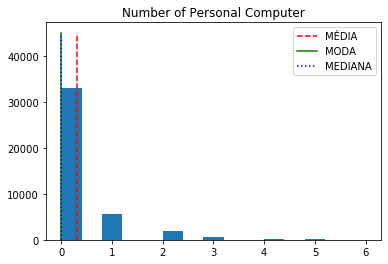

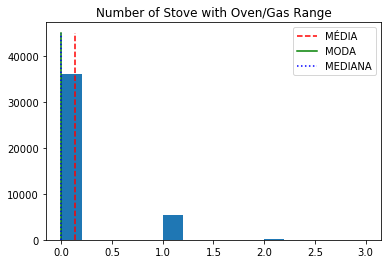

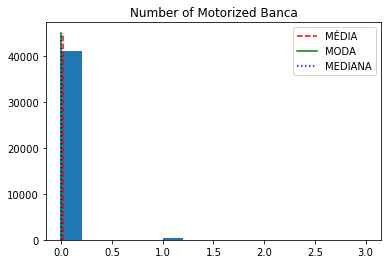

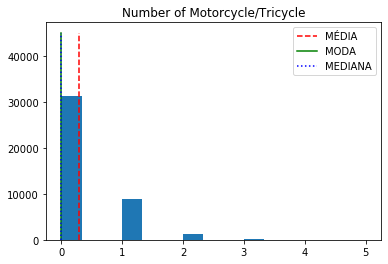

In [11]:
# histograma com média, moda, mediana
def distr_mean_mode_median(series, series_name, bins = 15, y_height = 45000):
    
    series_mean = series.mean()
    series_mode = stats.mode(series)[0][0]
    series_median = series.median()
    
    plt.hist(series, bins = bins)
    plt.plot([series_mean, series_mean], [0, y_height], linestyle = '--', color = 'red', label = 'MÉDIA')
    plt.plot([series_mode, series_mode], [0, y_height], linestyle = '-', color = 'green', label = 'MODA')
    plt.plot([series_median, series_median], [0, y_height], linestyle = ':', color = 'blue', label = 'MEDIANA')
    plt.title(series_name)
    plt.legend()
    plt.show()

# DISTRIBUIÇÕES DE TODAS AS VARIÁVEIS QUANTITATIVAS
for series_name in quant:       
    distr_mean_mode_median(df[series_name], series_name)

DISTRIBUIÇÃO APROXIMADAMENTE NORMAL


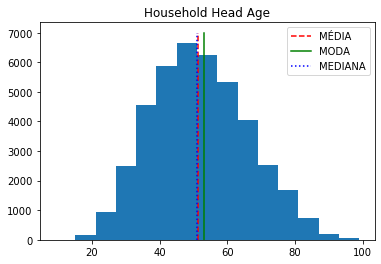

DISTRIBUIÇÃO POSITIVAMENTE ASSIMÉTRICA


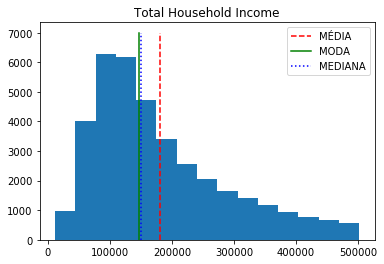

In [12]:
# EXEMPLOS DE TIPOS DE DISTRIBUIÇÃO
print('DISTRIBUIÇÃO APROXIMADAMENTE NORMAL')
distr_mean_mode_median(series = df['Household Head Age'], y_height = 7000, series_name = "Household Head Age")
print('DISTRIBUIÇÃO POSITIVAMENTE ASSIMÉTRICA')
df_m1_a6_positive_skew = drop_by_percentile(df['Total Household Income'])
distr_mean_mode_median(series = df_m1_a6_positive_skew, y_height = 7000, series_name = 'Total Household Income')

### MILESTONE 2
# INTERVALOS DE CONFIANÇA

In [13]:
# ------- 'Education Expenditure'
# intervalo de confiança nos dados cuja remoção de outliers foi feita por percentil(acima de 90)
outlier_by_percentile(df['Education Expenditure'], 90, 0)

df_ed_percentile_drop = drop_by_percentile(df['Education Expenditure'])

edexp_low, edexp_high = CI(df_ed_percentile_drop)

print('INTERVALO DE CONFIANÇA: {0} ~ {1}'.format(edexp_low, edexp_high))

MÉDIA APÓS ELIMINAR PERCENTIL 90 PARA CIMA: 2437.81
            //                0 PARA BAIXO: 7473.5
            //                90 PARA CIMA E 0 PARA BAIXO: 2437.81
-----------------------------------------------------------------------------------
VARIAÇÃO PERCENTUAL APÓS ELIMINAR PERCENTIL 90 PARA CIMA:  -67.38 %
                 //                         0 PARA BAIXO:  0.0 %
                 //                         90 PARA CIMA e 0 PARA BAIXO:  -67.38 %
INTERVALO DE CONFIANÇA: 1597.82 ~ 3452.0


In [14]:
# ------- 'Medical Care Expenditure'
# intervalo de confiança nos dados cuja remoção de outliers foi feita por percentil(acima de 90)

outlier_by_percentile(df['Medical Care Expenditure'], 90, 0)

df_med_percentile_drop = drop_by_percentile(df['Medical Care Expenditure'])

medexp_low, medexp_high = CI(df_med_percentile_drop)

print('INTERVALO DE CONFIANÇA: {0} ~ {1}'.format(medexp_low, medexp_high))

MÉDIA APÓS ELIMINAR PERCENTIL 90 PARA CIMA: 2296.17
            //                0 PARA BAIXO: 7160.23
            //                90 PARA CIMA E 0 PARA BAIXO: 2296.17
-----------------------------------------------------------------------------------
VARIAÇÃO PERCENTUAL APÓS ELIMINAR PERCENTIL 90 PARA CIMA:  -67.93 %
                 //                         0 PARA BAIXO:  0.0 %
                 //                         90 PARA CIMA e 0 PARA BAIXO:  -67.93 %
INTERVALO DE CONFIANÇA: 1643.07 ~ 2780.41


### MILESTONE 2
# TESTES DE HIPÓTESE

#### f < Valor Crítico(f) <-- variâncias iguais
#### f > Valor Crítico(f) <-- variâncias diferentes
#### distribuição amostral de proporções entre variâncias aproximadamente normal, em torno do 1 <-- variâncias iguais
#### distribuição amostral de proporções entre variâncias não é  aproximadamente normal, em torno do 1 <-- variâncias diferentes
#### t > Valor Crítico(t) <-- hipótese nula de médias iguais rejeitada
#### t < Valor Crítico(t) <-- hipótese nula de médias iguais não rejeitada

Valor f: 1.15
Valor Crítico(f): 2.12


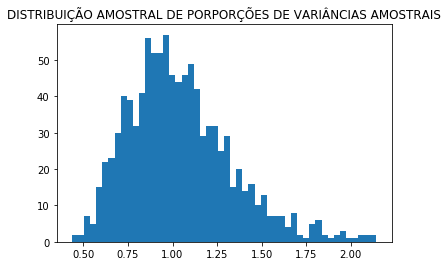

Valor t: 2.48
Valor Crítico(t): (+/-) 2.02


In [20]:
# ------- 'Household Head Sex' / 'Total Number of Family members'
mh = df.loc[df['Household Head Sex'] == 'Male', 'Total Number of Family members']
fh = df.loc[df['Household Head Sex'] == 'Female', 'Total Number of Family members']

variance_difference_hypothesis_test(mh, fh)
variance_ratio_sampling_distribution(mh, fh)

tval , dof = mean_difference_hypothesis_test(mh, fh, equal_var = True)

print('Valor t: {0}\nValor Crítico(t): (+/-) {1}'.format(round(tval, 2), round(abs(t.ppf(0.975, dof)), 2)))

Valor f: 2.67
Valor Crítico(f): 2.12


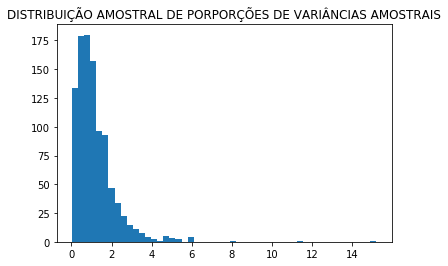

Valor t: 0.07
Valor Crítico(t): (+/-) 2.04


In [16]:
# ------- 'Main Source of Income' / 'Total Household Income'

income_x = df.loc[df['Main Source of Income'] == 'Wage/Salaries', 'Total Household Income']
income_y = df.loc[(df['Main Source of Income'] == 'Other sources of Income') |
                    (df['Main Source of Income'] == 'Enterpreneurial Activities'), 'Total Household Income']

variance_difference_hypothesis_test(income_x, income_y)
variance_ratio_sampling_distribution(income_x, income_y)

tval , dof = mean_difference_hypothesis_test(income_x, income_y, equal_var = False)

print('Valor t: {0}\nValor Crítico(t): (+/-) {1}'.format(round(tval, 2), round(abs(t.ppf(0.975, dof)), 2)))

### MILESTONE 3
# TESTE QUI-QUADRADO

In [17]:
# dividindo níveis de escolaridade em três categorias de acordo com duas palavras-chave: 'Programs', 'College'
# dados que não contivessem as duas palavras listadas acima foram alocados sob a categoria 'other'

gcs = 'Household Head Highest Grade Completed'
program = df.loc[df[gcs].str.contains('Programs')]
college = df.loc[df[gcs].str.contains('College')]
other = df.loc[(df[gcs].str.contains('College') == False) & (df[gcs].str.contains('Programs') == False)]

program['escolaridade'] = 'PROGRAM'
college['escolaridade'] = 'COLLEGE'
other['escolaridade'] = 'OTHER'
clear_output()

df_m3 = program.append([college, other])
ct = pd.crosstab(df_m3['Household Head Job or Business Indicator'], df_m3['escolaridade'])

chi_obs = chi2_2by3_contingency(ct)

print('Estatística Qui-Quadrada: {0}\nValor Crítico: 5.991'.format(round(chi_obs, 3)))

# Estatística Qui-Quadrada > Valor Crítico <-- hipótese nula de independência rejeitada

Estatística Qui-Quadrada: 138.636
Valor Crítico: 5.991
